In [51]:
from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister, Aer
from qiskit.circuit import Parameter
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info import Statevector
import numpy as np

# Data

* documents: `passport`,  `entry_pass`, `citizen_id`,  `work_pass`, `foreigner_id` and `person_characteristcs`
* imigrant data: `foreigner`, `worker` and `wanted`
* imigrant actions: `bribe`, `emotional_trick`, and `ezic_member`
* actions: `detain`, `check`, `use_weapon`, `confiscate_document` and `fingerprint`
* outputs: `let_pass` and `justify`
* events: `terrorist_attack`
* divergent information: `false_data`, `different_weight` and `different_characteristics`
* inputs : `join_ezic`

In [2]:
# documents
passport = QuantumRegister(1, name="passport")
entry_pass = QuantumRegister(1, name="entry_pass")
citizen_id = QuantumRegister(1, name="citizen_id")
work_pass = QuantumRegister(1, name="work_pass")
foreigner_id = QuantumRegister(1, name="foreigner_id")
person_characteristcs = QuantumRegister(1, name="person_characteristcs")
documents = [passport, entry_pass, citizen_id, work_pass, foreigner_id, person_characteristcs]

In [3]:
#imigrant data
foreigner = QuantumRegister(1, name="foreigner")
worker = QuantumRegister(1, name="worker")
wanted = QuantumRegister(1, name="wanted")
imigrant_data = [foreigner, worker, wanted]

In [4]:
#imigrant actions
bribe = QuantumRegister(1, name="bribe")
emotional_trick = QuantumRegister(1, name="emotional_trick")
ezic_member = QuantumRegister(1, name="ezic_member")
imigrant_actions = [bribe, emotional_trick, ezic_member]

In [5]:
#actions
detain = QuantumRegister(1, name="detain")
check = QuantumRegister(1, name="check")
use_weapon = QuantumRegister(1, name="use_weapon")
confiscate_document = QuantumRegister(1, name="confiscate_document")
fingerprint = QuantumRegister(1, name="fingerprint")
actions = [detain, check, use_weapon, confiscate_document, fingerprint]

In [12]:
#outputs
let_pass = QuantumRegister(1, name="let_pass")
justify = QuantumRegister(1, name="justify")
outputs = [let_pass, justify]

In [14]:
#events
terrorist_attack = QuantumRegister(1, name="terrorist_attack")
events = [terrorist_attack]

In [17]:
#divergent_information
false_data = QuantumRegister(1, name="false_data")
different_weight = QuantumRegister(1, name="different_weight")
different_characteristics = QuantumRegister(1, name="different_characteristics")
divergent_information = [false_data, different_weight, different_characteristics]

In [19]:
#inputs
join_ezic = QuantumRegister(1, name="join_ezic")
inputs = [join_ezic]

In [52]:
#measurements
out = ClassicalRegister(2, name="out")

In [42]:
def generate_superposition(circuit, qubits):
    for qubit in qubits:
        circuit.h(qubit)
    return circuit

In [47]:
def add_inputs_parameters(circuit, qubits, parameters):
    for qubit, parameter in zip(qubits, parameters):
        circuit.ry(parameter, qubit)
    return circuit

In [65]:
def add_measurements(circuit, qubits, clbits):
    for qubit, clbit in zip(qubits, clbits):
        circuit.measure(qubit, clbit)
    return circuit

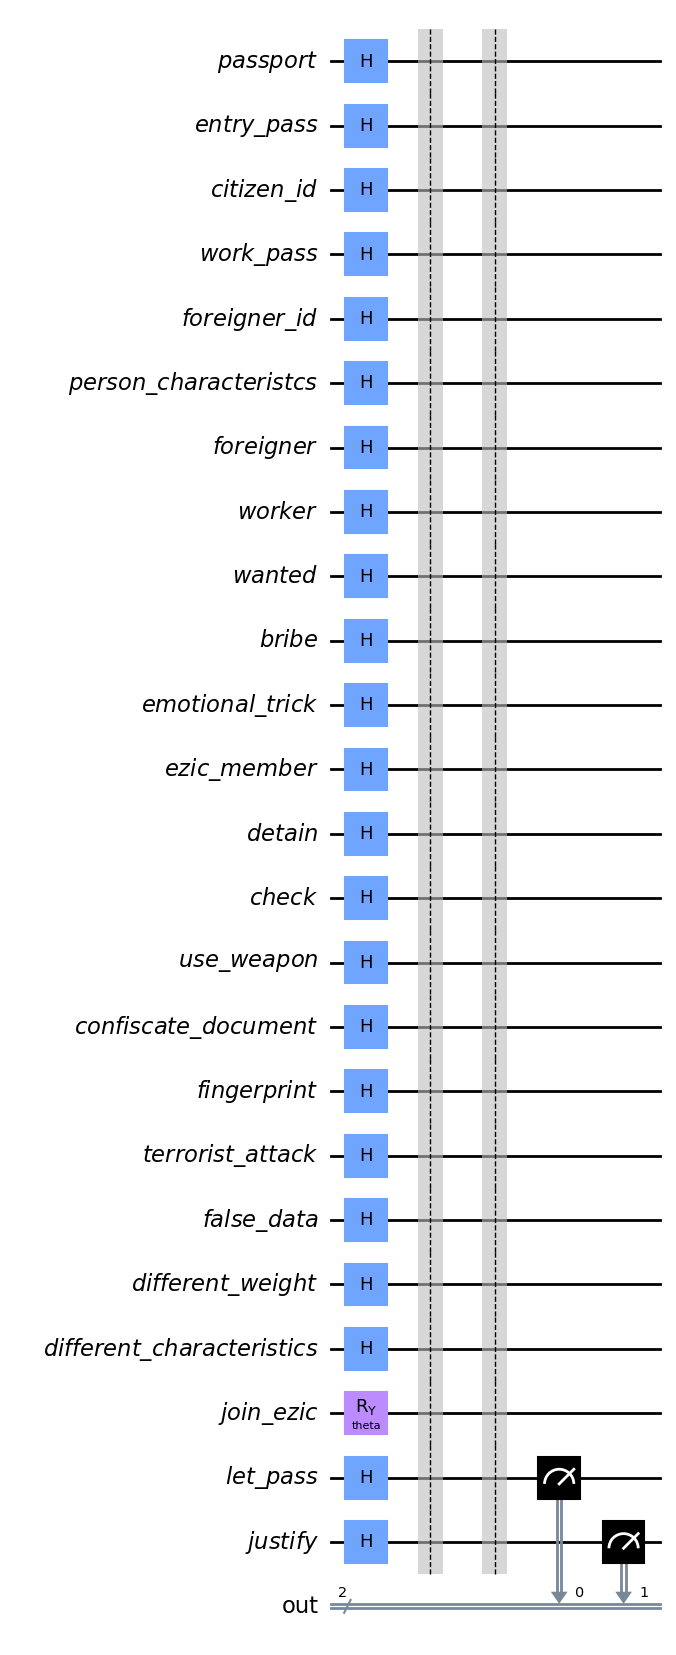

In [68]:
theta = Parameter('theta')
parameters = [theta]


qc = QuantumCircuit(*documents, *imigrant_data, *imigrant_actions, *actions, *events, *divergent_information, *inputs, *outputs, out)
qc = generate_superposition(qc, [*documents, *imigrant_data, *imigrant_actions, *actions, *outputs, *events, *divergent_information])
qc = add_inputs_parameters(qc, inputs, parameters)

qc.barrier()

qc.barrier()

qc = add_measurements(qc, outputs, out)

qc.draw('mpl')

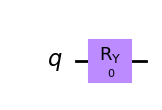

<IPython.core.display.Latex object>

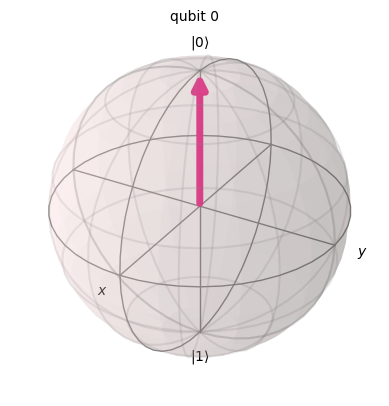

In [34]:
test = QuantumCircuit(1)
test.ry(0, 0)
display(test.draw("mpl"))
display(Statevector(test).draw('latex'))
plot_bloch_multivector(test)